In [1]:
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from bbutils.utils import *
from tqdm import tqdm
%matplotlib inline

COLUMN_WIDTH = 3.25  # Inches
TEXT_WIDTH = 6.299213  # Inches
GOLDEN_RATIO = 1.61803398875
DPI = 300
FONT_SIZE = 8

mpl.rcParams['font.size'] = FONT_SIZE
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times']
# mpl.rcParams['text.usetex'] = True

mpl.rcParams['text.usetex'] = False
from bbutils import BetaBernoulli

In [2]:
category2idx = dict()
idx2category = []
categories = []
observations = []

with open('data/cifar100/predictions.txt', 'r') as f:
    next(f)
    for line in f:
        _, correct, predicted, confidence = line.split()
        if predicted not in category2idx:
            category2idx[predicted] = len(category2idx)
            idx2category.append(predicted)
        idx = category2idx[predicted]
        categories.append(idx)
        observations.append(correct == predicted)
num_classes = 100

In [3]:
n_pool = np.array([(np.array(categories) == _).sum() for _ in range(num_classes)])
theta_prior = None
N = int(len(observations) / 10)
num_runs = 10

In [4]:
active_choices = np.zeros((num_runs , N, 2))
random_choices = np.zeros((num_runs , N, 2))

for r in tqdm(range(num_runs)):
    
    ###### RANDOM SAMPLING
    deque_random = deepcopy(list(zip(categories, observations)))
    random.shuffle(deque_random)
    for i in range(N):
        category, observation = deque_random.pop()
        random_choices[r, i] = category, observation
        
    ###### OPTIMAL SAMPLING
    n_current = np.zeros(num_classes)
    deques = prepare_deques(categories, observations, num_classes)        
    for i in range(N):
        n_opt = get_n_opt(n_pool, active_choices[r], i+1, num_classes, theta_prior)
        category_opt = get_category_opt(n_pool, n_current, n_opt, mode="KL")
        n_current[category_opt] += 1
        active_choices[r, i] = category_opt, deques[category_opt].pop()

100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


{0.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0}

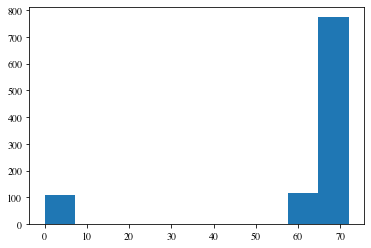

In [33]:
plt.hist(active_choices[0,:, 0]);
set(active_choices[0,:, 0])

In [13]:
overall_accuracy_random = np.zeros((num_runs, N))
overall_accuracy_active = np.zeros((num_runs, N))

def get_overall_accuracy(choices, n_pool, theta_prior = None):
    p_pool = n_pool / n_pool.sum()
    theta_hat = get_theta_hat(choices, n_pool.shape[0], theta_prior)
    return (theta_hat * p_pool).sum()

for r in range(num_runs):
    for i in range(1, N):
        overall_accuracy_random[r, i] = random_choices[r, :i, 1].sum() / i
        overall_accuracy_active[r, i] = get_overall_accuracy(active_choices[r, :i], n_pool, theta_prior)

(999,)
(999,)


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text xticklabel objects>)

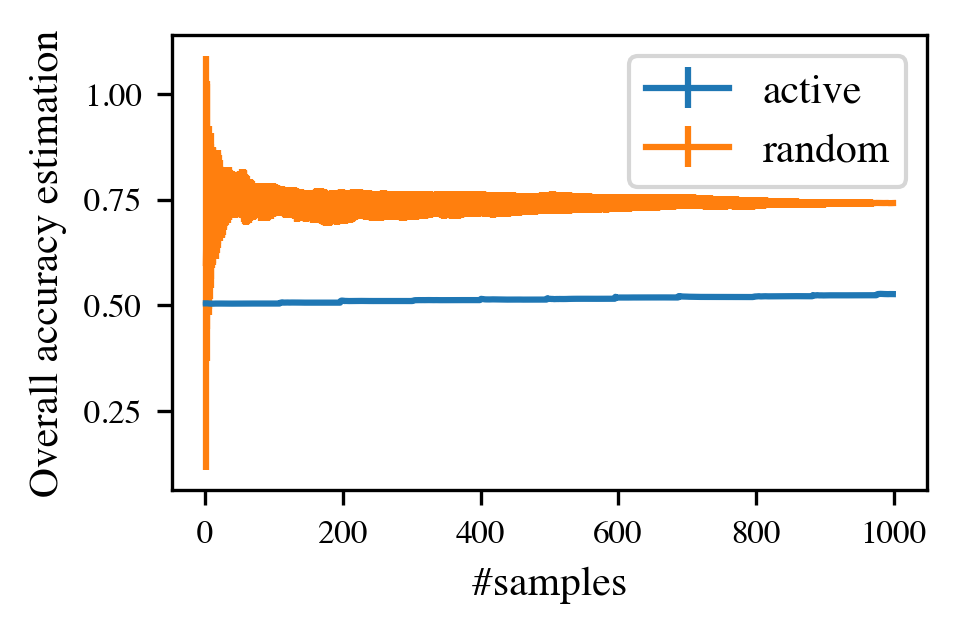

In [27]:
# If labels are getting cut off make the figsize smaller
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH / GOLDEN_RATIO), dpi=300)

## PLOT STUFF ##
accuracy_active_mean = overall_accuracy_active.mean(axis = 0)[1:]
accuracy_active_err = np.std(overall_accuracy_active, axis=0)[1:]
accuracy_random_mean = overall_accuracy_random.mean(axis = 0)[1:]
accuracy_random_err = np.std(overall_accuracy_random, axis=0)[1:]
print(accuracy_active_mean.shape)
print(accuracy_active_err.shape)
plt.errorbar([i for i in range(1, N)], accuracy_active_mean, yerr = accuracy_active_err, label='active')
plt.errorbar([i for i in range(1, N)], accuracy_random_mean, yerr = accuracy_random_err, label='random')
plt.xlabel('#samples')
plt.ylabel('Overall accuracy estimation')
plt.legend()

# FORMAT STUFF ##
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)